In [264]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller # Test de Dickey-Fuller pour vérifier la stationnarité
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Charger les données

In [188]:
df = pd.read_csv('data_projet/MilwaukeePropertySalesData.csv')

# Affichage d'un aperçu des données

In [191]:
df['FinishedSqft'].describe()

count      5805.000000
mean       2052.659948
std        5753.813684
min           0.000000
25%        1073.000000
50%        1368.000000
75%        1960.000000
max      280872.000000
Name: FinishedSqft, dtype: float64

# ---------------------------------------------------------------------
# Question 1 : Identification et suppression des valeurs extrêmes
# ---------------------------------------------------------------------

## Étape 1 : Calcul des limites

In [195]:
# Calcul des quartiles
Q1 = df['FinishedSqft'].quantile(0.25)  # 25e percentile
Q3 = df['FinishedSqft'].quantile(0.75)  # 75e percentile
IQR = Q3 - Q1                           # Calcul de l'IQR

# Définition des limites
lower_bound = Q1 - 1.5 * IQR  # Limite inférieure
upper_bound = Q3 + 1.5 * IQR  # Limite supérieure

print(f"Limite inférieure : {lower_bound}, Limite supérieure : {upper_bound}")


Limite inférieure : -257.5, Limite supérieure : 3290.5


## Étape 3 : Identifier les valeurs extrêmes

In [198]:
# Filtre des valeurs extrêmes
outliers = df[(df['FinishedSqft'] < lower_bound) | (df['FinishedSqft'] > upper_bound)]

print(f"Nombre de valeurs extrêmes : {len(outliers)}")
print(outliers[['FinishedSqft']])


Nombre de valeurs extrêmes : 329
      FinishedSqft
0          12960.0
26          3738.0
34         21675.0
75          3700.0
77          4936.0
...            ...
5690       28079.0
5756        4778.0
5758        4358.0
5796       10870.0
5797       18953.0

[329 rows x 1 columns]


## Étape 4 : Nettoyage des données

In [201]:
# Garder uniquement les valeurs dans les limites
df_cleaned = df[(df['FinishedSqft'] >= lower_bound) & (df['FinishedSqft'] <= upper_bound)]

print(f"Taille des données nettoyées : {df_cleaned.shape}")


Taille des données nettoyées : (5476, 21)


##  Étape 5 : Visualisation pour confirmer

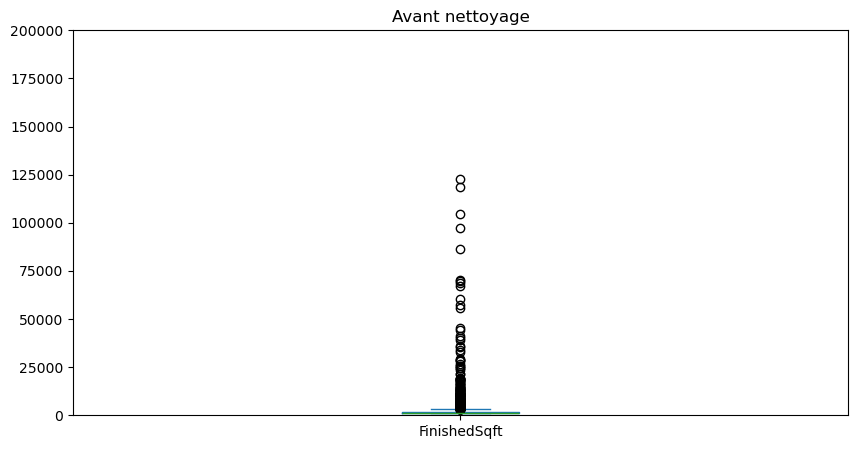

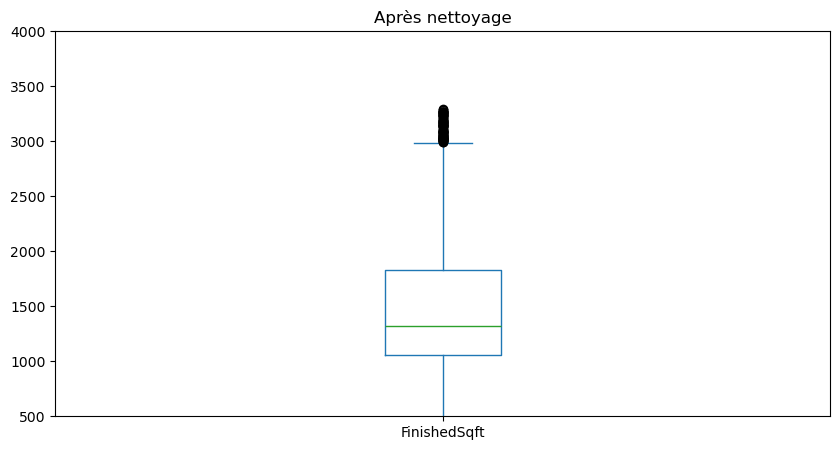

In [204]:

# Avant nettoyage
plt.figure(figsize=(10, 5))
df['FinishedSqft'].plot(kind='box', title='Avant nettoyage')
plt.ylim(0, 200000)
# Après nettoyage
plt.figure(figsize=(10, 5))
df_cleaned['FinishedSqft'].plot(kind='box', title='Après nettoyage')
plt.ylim(500, 4000)
plt.show()






Les valeurs inférieures à la limite inférieure ou supérieures à la limite supérieure sont considérées comme des valeurs extrêmes et peuvent être supprimées.

En utilisant l'IQR, nous identifions les valeurs qui s'écartent trop de la majorité des données. En supprimant ces valeurs :
* On obtient une analyse plus représentative des surfaces typiques.
* Les statistiques comme la moyenne ou la médiane ne seront pas biaisées.
* Les modèles (par exemple, la régression ou le clustering) auront des résultats plus précis.

# --------------------------------------------------------------------------------------------
# Question 2 : Test d'hypothèse sur le prix de vente moyen des propriétés résidentielles dans le District 11
# --------------------------------------------------------------------------------------------

### Nettoyage de données:

In [209]:
# Suppression des lignes avec des valeurs manquantes dans 'FinishedSqft'
df_cleaned = df.dropna(subset=['FinishedSqft'])

# Remplissage des valeurs manquantes par la moyenne ou la médiane
df['FinishedSqft'].fillna(df['FinishedSqft'].median(), inplace=True)


In [211]:
# Filtrage des données pour le District 11 et les propriétés résidentielles
df_district_11 = df_cleaned[(df_cleaned['District'] == 11) & (df_cleaned['PropType'] == 'Residential')]

# Vérification du nombre de propriétés
n = df_district_11.shape[0]
print(f"Nombre de propriétés dans le District 11 : {n}")

# Calcul de la moyenne et de l'écart-type des prix de vente
mean_price = df_district_11['Sale_price'].mean()
std_dev = df_district_11['Sale_price'].std()

print(f"Moyenne des prix dans le District 11 : {mean_price}")
print(f"Écart-type des prix dans le District 11 : {std_dev}")

# Test d'hypothèse unilatéral : On veut tester si le prix moyen est supérieur à 250 000 $
mu_0 = 250000  # Moyenne hypothétique
alpha = 0.05  # Niveau de signification

# Calcul de la statistique t et de la p-value
t_stat, p_value = stats.ttest_1samp(df_district_11['Sale_price'], mu_0)

# Affichage des résultats du test
print(f"Valeur t : {t_stat}")
print(f"Valeur p (test bilatéral) : {p_value}")

# Comme c'est un test unilatéral, on divise la p-value par 2
p_value_one_sided = p_value / 2

# Conclusion
if p_value_one_sided < alpha and t_stat > 0:
    print("Nous rejetons l'hypothèse nulle : il y a suffisamment de preuves pour dire que le prix moyen est supérieur à 250 000 $.")
else:
    print("Nous ne rejetons pas l'hypothèse nulle : il n'y a pas suffisamment de preuves pour dire que le prix moyen est supérieur à 250 000 $.")


Nombre de propriétés dans le District 11 : 406
Moyenne des prix dans le District 11 : 252977.58374384238
Écart-type des prix dans le District 11 : 59861.08975489494
Valeur t : 1.0022645801866716
Valeur p (test bilatéral) : 0.3168142642416812
Nous ne rejetons pas l'hypothèse nulle : il n'y a pas suffisamment de preuves pour dire que le prix moyen est supérieur à 250 000 $.


# --------------------------------------------------------------------------------------------
# Question 3 : Test d'hypothèse sur la différence de superficie habitable moyenne entre les propriétés construites avant 1950 et celles construites après 1950
# --------------------------------------------------------------------------------------------

In [214]:
# Sélectionner les propriétés résidentielles
df_residential = df_cleaned[df_cleaned['PropType'] == 'Residential']

# Créer les deux groupes (avant 1950 et après ou en 1950)
group_before_1950 = df_residential[df_residential['Year_Built'] < 1950]['FinishedSqft']
group_after_1950 = df_residential[df_residential['Year_Built'] >= 1950]['FinishedSqft']

# Vérifier l'homogénéité des variances avec le test de Levene
stat_levene, p_levene = stats.levene(group_before_1950, group_after_1950)
print(f"Levene test statistic: {stat_levene}, p-value: {p_levene}")

# Si p-value de Levene > 0.05, on peut utiliser le test t classique, sinon le test t de Welch (si variances inégales)
if p_levene > 0.05:
    # Test t de Student pour échantillons indépendants (égalité des variances)
    t_stat, p_value = stats.ttest_ind(group_before_1950, group_after_1950)
    print(f"Test t-statistic: {t_stat}, p-value: {p_value}")
else:
    # Test t de Welch (si les variances sont inégales)
    t_stat, p_value = stats.ttest_ind(group_before_1950, group_after_1950, equal_var=False)
    print(f"Test t-statistic (Welch): {t_stat}, p-value: {p_value}")

# Interprétation des résultats
alpha = 0.05
if p_value < alpha:
    print("Nous rejetons l'hypothèse nulle : Il existe une différence significative dans la superficie habitable moyenne.")
else:
    print("Nous ne rejetons pas l'hypothèse nulle : Il n'y a pas de différence significative dans la superficie habitable moyenne.")


Levene test statistic: 114.13364773043978, p-value: 2.455563002596646e-26
Test t-statistic (Welch): 18.84325457826026, p-value: 2.2076730644222182e-76
Nous rejetons l'hypothèse nulle : Il existe une différence significative dans la superficie habitable moyenne.


# --------------------------------------------------------------------------------------------
# Question 4 : Test d'hypothèse pour déterminer l'association entre le nombre de chambres et le prix de vente (au-dessus ou en dessous de la médiane)
# --------------------------------------------------------------------------------------------

Nous avons utilisé un test du Khi-deux d'indépendance pour déterminer s'il existe une relation significative entre le nombre de chambres d'une propriété et sa catégorie de prix (au-dessus ou en dessous de la médiane). Le test permet de vérifier si ces deux variables catégorielles sont indépendantes ou si elles sont associées. Si la p-value est inférieure à 0.05, nous rejetons l'hypothèse nulle et concluons qu'il existe une association significative entre le nombre de chambres et le prix de vente médian de la propriété.

In [225]:
# Création d'une nouvelle colonne 'Prix_median' pour savoir si le prix de vente est au-dessus ou en dessous de la médiane
prix_median = df_cleaned['Sale_price'].median()
df_cleaned.loc[:, 'Prix_median'] = df_cleaned['Sale_price'].apply(lambda x: 'Au-dessus de la médiane' if x > prix_median else 'En-dessous de la médiane')

# Regroupement des propriétés ayant 5 chambres ou plus dans la même catégorie
df_cleaned.loc[:, 'Bdrms_cat'] = df_cleaned['Bdrms'].apply(lambda x: x if x < 5 else 5)

# Création d'une table de contingence
contingency_table = pd.crosstab(df_cleaned['Bdrms_cat'], df_cleaned['Prix_median'])

# Affichage de la table de contingence
print("Table de contingence :")
print(contingency_table)

# Test du Khi-deux pour l'indépendance
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Affichage des résultats du test du Khi-deux
print(f"Statistique du Khi-deux: {chi2_stat}")
print(f"Degrés de liberté: {dof}")
print(f"p-value: {p_value}")

# Interprétation des résultats
alpha = 0.05
if p_value < alpha:
    print("Nous rejetons l'hypothèse nulle : Il existe une association significative entre le nombre de chambres et la catégorie de prix.")
else:
    print("Nous ne rejetons pas l'hypothèse nulle : Il n'y a pas d'association significative entre le nombre de chambres et la catégorie de prix.")


Table de contingence :
Prix_median  Au-dessus de la médiane  En-dessous de la médiane
Bdrms_cat                                                     
0.0                                2                        12
1.0                              131                        93
2.0                              416                       611
3.0                             1074                      1051
4.0                              503                       666
5.0                              765                       481
Statistique du Khi-deux: 138.234499889729
Degrés de liberté: 5
p-value: 4.245157690166608e-28
Nous rejetons l'hypothèse nulle : Il existe une association significative entre le nombre de chambres et la catégorie de prix.


# --------------------------------------------------------------------------------------------
# Question 5 : Variation du prix moyen de vente par mois
# --------------------------------------------------------------------------------------------

Nous allons calculer le pourcentage de variation du prix moyen de vente d'un mois à l'autre. Cela nous permet d'analyser l'évolution des prix au fil du temps. 
Ensuite, nous allons visualiser ces variations par mois sous forme de graphique, ce qui nous permettra d'observer les tendances et les fluctuations des prix.

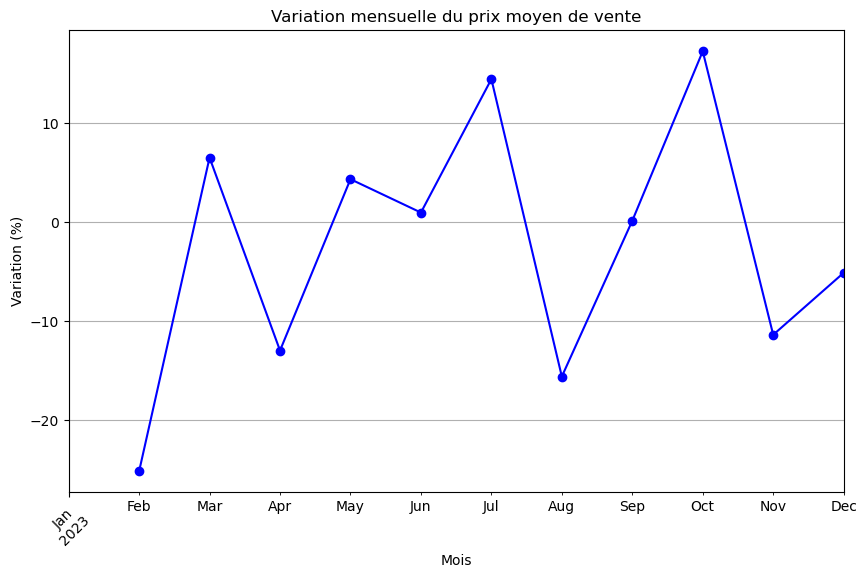

In [233]:
# Extraction de l'année et du mois de la date de vente
df_cleaned.loc[:, 'Sale_date'] = pd.to_datetime(df_cleaned['Sale_date'])
df_cleaned.loc[:, 'Year_Month'] = df_cleaned['Sale_date'].dt.to_period('M')

# Calcul du prix moyen par mois
monthly_avg_price = df_cleaned.groupby('Year_Month')['Sale_price'].mean()

# Calcul de la variation du prix moyen d'un mois à l'autre
monthly_price_variation = monthly_avg_price.pct_change() * 100

# Création du graphique
plt.figure(figsize=(10, 6))
monthly_price_variation.plot(kind='line', marker='o', color='b', title="Variation mensuelle du prix moyen de vente", xlabel="Mois", ylabel="Variation (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


# --------------------------------------------------------------------------------------------
# Question 6 : Vérification de la stationnarité de la série temporelle des propriétés vendues quotidiennement
# --------------------------------------------------------------------------------------------

L'objectif de cette analyse est de vérifier si la série temporelle du nombre de propriétés vendues quotidiennement est stationnaire. Une série temporelle est dite stationnaire si ses propriétés statistiques, telles que la moyenne, la variance et l'autocorrélation, ne changent pas au fil du temps. Pour cela, nous allons utiliser le test d'Augmented Dickey-Fuller (ADF), qui est un test statistique permettant de vérifier l'hypothèse nulle selon laquelle une série temporelle a une racine unitaire et n'est donc pas stationnaire.

L'hypothèse nulle (H₀) du test ADF est que la série temporelle a une racine unitaire, ce qui signifie qu'elle n'est pas stationnaire. Si la p-value obtenue est inférieure à un seuil critique (généralement 0.05), nous rejetons l'hypothèse nulle et conclurons que la série est stationnaire. En revanche, si la p-value est supérieure à ce seuil, cela signifie que nous ne pouvons pas rejeter l'hypothèse nulle et que la série n'est pas stationnaire.

ADF : -5.445406252072158
p-value: 2.7175722905188624e-06
Valeurs critiques: {'1%': -3.4519023023726696, '5%': -2.8710320399170537, '10%': -2.57182745012602}
La série est stationnaire (on rejette l'hypothèse nulle).


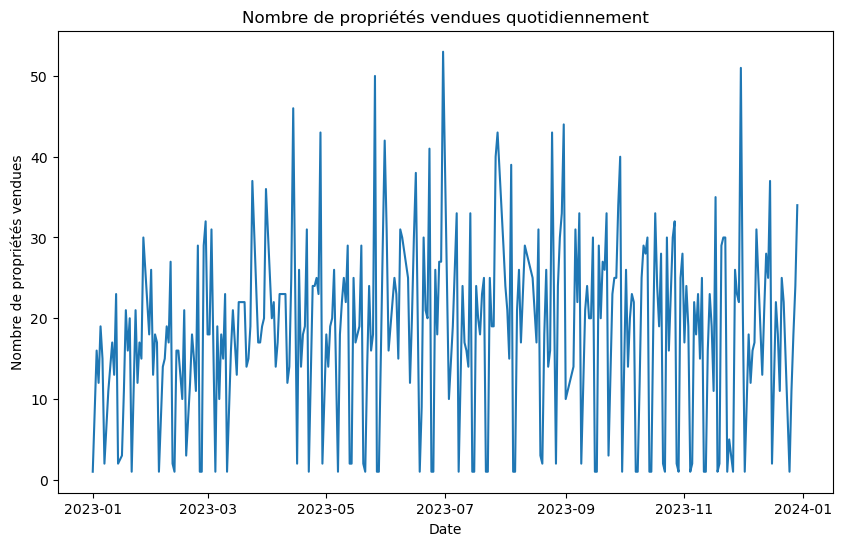

In [252]:
# Assurez-vous d'utiliser .loc pour éviter le SettingWithCopyWarning
df_cleaned.loc[:, 'Sale_date'] = pd.to_datetime(df_cleaned['Sale_date'])

# Calcul du nombre de propriétés vendues quotidiennement
daily_sales = df_cleaned.groupby(df_cleaned['Sale_date'].dt.date).size()

adf_result = adfuller(daily_sales)

# Affichage des résultats du test ADF
print(f"ADF : {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Valeurs critiques: {adf_result[4]}")

# Interprétation du test
if adf_result[1] < 0.05:
    print("La série est stationnaire (on rejette l'hypothèse nulle).")
else:
    print("La série n'est pas stationnaire (on ne rejette pas l'hypothèse nulle).")

# Visualisation de la série
plt.figure(figsize=(10, 6))
daily_sales.plot(title='Nombre de propriétés vendues quotidiennement')
plt.xlabel('Date')
plt.ylabel('Nombre de propriétés vendues')
plt.show()

# --------------------------------------------------------------------------------------------
# Question 7 : Regroupement des ventes de propriétés immobilières du mois de juin avec K-means et méthode du coude
# --------------------------------------------------------------------------------------------

L'objectif ici est de réaliser un regroupement des ventes de propriétés immobilières pour le mois de juin à l'aide de l'algorithme K-means. Nous allons expérimenter avec différents nombres de clusters et utiliser la méthode du coude pour déterminer le nombre optimal de groupes.

Nous discuterons des choix des variables utilisées pour effectuer le regroupement et fournirons des descriptions des clusters obtenus à l'aide de graphiques pertinents.

In [294]:
import os
os.environ["OMP_NUM_THREADS"] = "3"
import warnings
#Cette ligne a pour objectif de filtrer les avertissements générés par scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn") 
# Activer la copie sur écriture
#Afin d'éviter l'avertissement SettingWithCopyWarning dans notre code, nous avons activé la fonctionnalité copy_on_write de pandas.
# Cela garantit que les modifications effectuées sur les DataFrame sont traitées de manière sûre et explicite.
#Sans cette option, pandas pourrait tenter de modifier une "vue" d'un DataFrame, ce qui peut entraîner des résultats inattendus et des avertissements.
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True 

#Ce code permet d'améliorer la lisibilité et d'éviter que des avertissements fréquents ne polluent la sortie

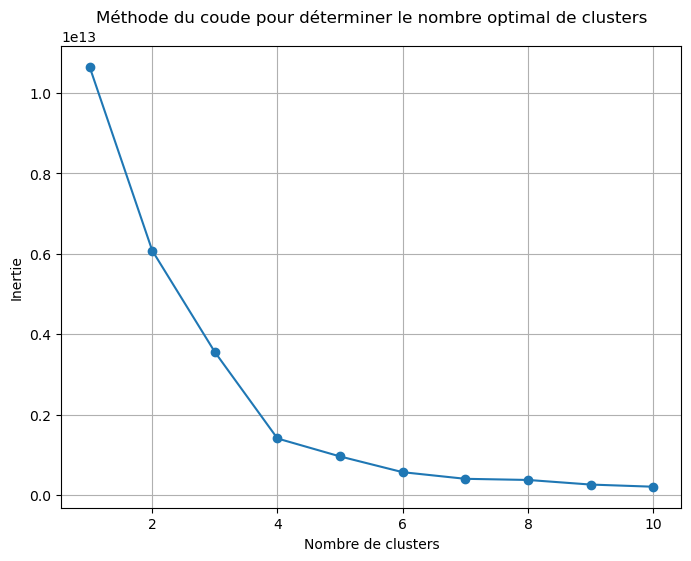

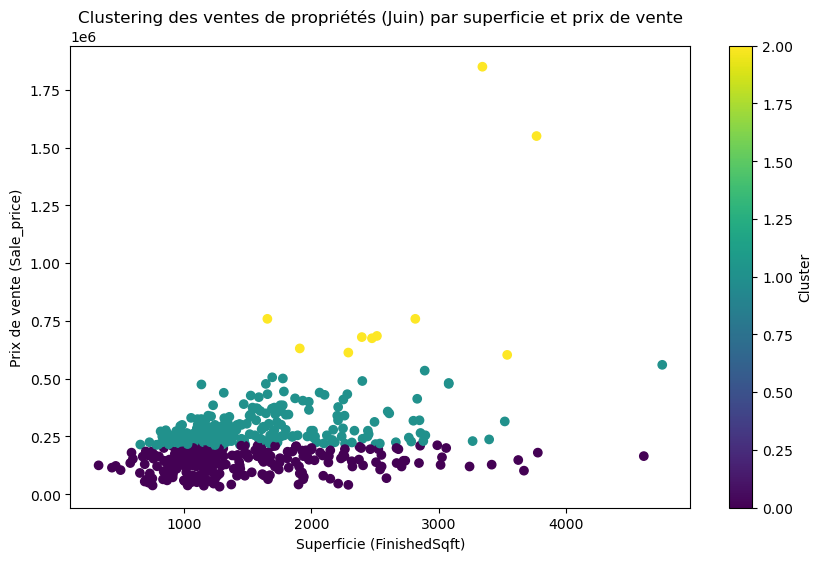

Centres des clusters :
 [[1.41526011e+05 1.42738849e+03 3.35971223e+00 5.02799281e+03]
 [2.84415915e+05 1.55830364e+03 3.68016194e+00 5.54932794e+03]
 [8.80500000e+05 2.67110000e+03 3.90000000e+00 4.22400000e+03]]
            Sale_price                                 FinishedSqft  \
                  mean            std     min      max         mean   
Cluster                                                               
0        141526.010791   47230.324811   32500   212000  1427.388489   
1        284415.914980   69210.521210  213000   560000  1558.303644   
2        880500.000000  440851.259875  603000  1850000  2671.100000   

                                        Bdrms                       \
                std     min     max      mean       std  min   max   
Cluster                                                              
0        659.971977   325.0  4615.0  3.359712  1.432007  0.0   9.0   
1        597.387395   653.0  4760.0  3.680162  1.849778  1.0  13.0   
2        

In [296]:
# 1. Filtrage des données pour le mois de juin
df_cleaned['Sale_date'] = pd.to_datetime(df_cleaned['Sale_date'])
df_june = df_cleaned[df_cleaned['Sale_date'].dt.month == 6]

# 2. Sélection des variables pertinentes pour le regroupement
variables = ['Sale_price', 'FinishedSqft', 'Bdrms', 'Lotsize']  # Choix des variables pour le regroupement
df_june_subset = df_june[variables].dropna()  # On supprime les valeurs manquantes

# 3. Utilisation de la méthode du coude pour déterminer le nombre optimal de clusters
inertia = []  # Liste pour stocker l'inertie

# Essayer différents nombres de clusters (de 1 à 10 ici)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_june_subset)
    inertia.append(kmeans.inertia_)  # Inertie : somme des distances au centre des clusters

# 4. Graphique de la méthode du coude
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Méthode du coude pour déterminer le nombre optimal de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.grid(True)
plt.show()

# À ce stade, nous devons choisir le nombre optimal de clusters en fonction du graphique.
# Supposons que nous choisissons K=3 comme étant optimal.

# 5. Appliquer K-means avec K=3
kmeans = KMeans(n_clusters=3, random_state=42)
df_june_subset['Cluster'] = kmeans.fit_predict(df_june_subset)  # Ajouter la colonne Cluster

# 6. Visualisation des clusters (ici en fonction de 2 variables)
plt.figure(figsize=(10, 6))
plt.scatter(df_june_subset['FinishedSqft'], df_june_subset['Sale_price'], c=df_june_subset['Cluster'], cmap='viridis')
plt.title("Clustering des ventes de propriétés (Juin) par superficie et prix de vente")
plt.xlabel('Superficie (FinishedSqft)')
plt.ylabel('Prix de vente (Sale_price)')
plt.colorbar(label='Cluster')
plt.show()

# 7. Description des clusters obtenus
# Affichons les centres des clusters et quelques statistiques descriptives des clusters
centroids = kmeans.cluster_centers_
print("Centres des clusters :\n", centroids)

# Ajout de la colonne Cluster au DataFrame original pour les statistiques par cluster
df_june_subset['Cluster'] = df_june_subset['Cluster']

# Calcul des statistiques par cluster
cluster_stats = df_june_subset.groupby('Cluster').agg({
    'Sale_price': ['mean', 'std', 'min', 'max'],
    'FinishedSqft': ['mean', 'std', 'min', 'max'],
    'Bdrms': ['mean', 'std', 'min', 'max'],
    'Lotsize': ['mean', 'std', 'min', 'max']
})

print(cluster_stats)


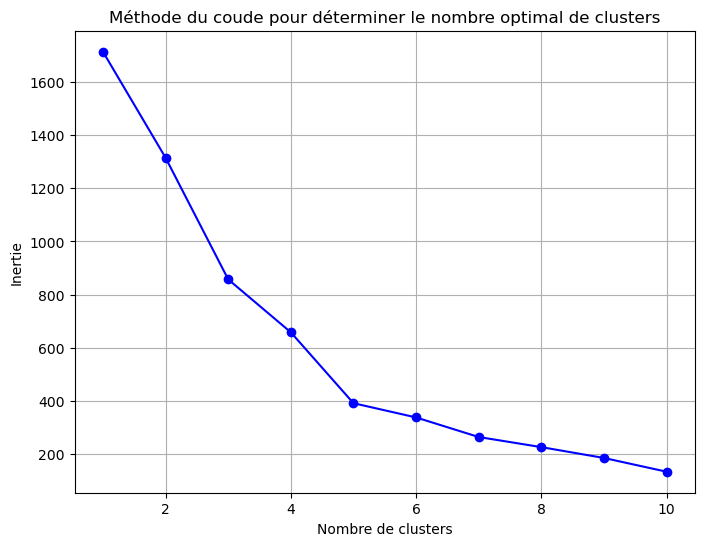

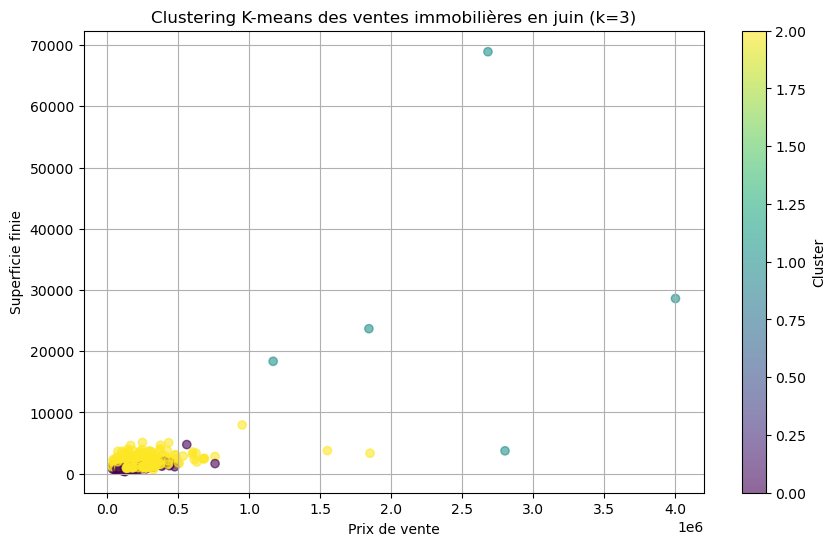

           Sale_price                FinishedSqft                   Bdrms  \
                 mean           std          mean           std      mean   
Cluster                                                                     
0        1.993597e+05  1.172543e+05   1051.931034    464.263001  1.758621   
1        2.498000e+06  1.069996e+06  28664.000000  24356.556817       NaN   
2        2.323018e+05  1.500676e+05   1750.340000    827.374088  4.004773   

                   
              std  
Cluster            
0        0.486705  
1             NaN  
2        1.521764  


In [288]:


# Étape 1: Chargement des données et prétraitement
df_cleaned.loc[:, 'Sale_date'] = pd.to_datetime(df_cleaned['Sale_date'])  # Utilisation de .loc pour éviter l'avertissement

# Filtrer les données pour le mois de juin
df_june = df_cleaned[df_cleaned['Sale_date'].dt.month == 6]

# Sélection des variables pour K-means
df_june_kmeans = df_june[['Sale_price', 'FinishedSqft', 'Bdrms']]  # Remplacez par les colonnes pertinentes

# Étape 2: Gérer les valeurs manquantes
imputer = SimpleImputer(strategy='mean')  # Remplacer les NaN par la moyenne de chaque colonne
df_june_kmeans_imputed = imputer.fit_transform(df_june_kmeans)

# Étape 3: Normaliser les données
scaler = StandardScaler()
df_june_kmeans_scaled = scaler.fit_transform(df_june_kmeans_imputed)

# Étape 4: Méthode du coude pour déterminer le nombre optimal de clusters
inertia = []  # Liste pour stocker l'inertie
for k in range(1, 11):  # Tester de 1 à 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_june_kmeans_scaled)
    inertia.append(kmeans.inertia_)

# Tracer la courbe de l'inertie pour la méthode du coude
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', color='b')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid(True)
plt.show()

# Étape 5: Appliquer K-means avec le nombre optimal de clusters (par exemple k=3 ici)
optimal_k = 3  # Vous pouvez ajuster ce nombre selon la courbe du coude
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# Créer une copie de df_june pour éviter les problèmes de vue
df_june = df_june.copy()

# Maintenant, vous pouvez ajouter la colonne Cluster sans avertissement
df_june['Cluster'] = kmeans.fit_predict(df_june_kmeans_scaled)


# Étape 6: Visualisation des clusters obtenus
plt.figure(figsize=(10, 6))

# Visualisation 2D (par exemple en fonction de 'Sale_price' et 'FinishedSqft')
plt.scatter(df_june['Sale_price'], df_june['FinishedSqft'], c=df_june['Cluster'], cmap='viridis', alpha=0.6)
plt.title(f'Clustering K-means des ventes immobilières en juin (k={optimal_k})')
plt.xlabel('Prix de vente')
plt.ylabel('Superficie finie')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Étape 7: Décrire les regroupements obtenus
cluster_summary = df_june.groupby('Cluster').agg({
    'Sale_price': ['mean', 'std'],
    'FinishedSqft': ['mean', 'std'],
    'Bdrms': ['mean', 'std']
})

print(cluster_summary)
